# Predicting Heart Disease - Machine Learning

This notebook looks into using various Python-based machine learning and data science libraries in an attempt to build and train a machine learning model capable of predicting if a patient has heart disease based on numourous health parameters.


This will employ the following:

1. Problem definition
2. Exploratory Data Analysis
3. Data Preprocessing
4. Modelling
5. Evaluation
6. Feature Importance (Selected Model)


## 1. Problem Definition

Is it possible to predict if a patient has heart disease via a machine learning modal given access to various health markers?

> If we can reach 95% accuracy at predicting weather ot not a patient has heart disease durining the proof of concept, we'll pursue the project.


### Data

The original dataset being used is from: https://archive.ics.uci.edu/dataset/45/heart+disease

**Data dictionary**

1. age - age in years
2. sex - (1 = male; 0 = female)
3. cp - chest pain type
   - 0: Typical angina: chest pain related decrease blood supply to the heart
   - 1: Atypical angina: chest pain not related to heart
   - 2: Non-anginal pain: typically esophageal spasms (non heart related)
   - 3: Asymptomatic: chest pain not showing signs of disease
4. trestbps - resting blood pressure (in mm Hg on admission to the hospital)
   - anything above 130-140 is typically cause for concern
5. chol - serum cholestoral in mg/dl
   - serum = LDL + HDL + .2 \* triglycerides
   - above 200 is cause for concern
6. fbs - (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)
   - '>126' mg/dL signals diabetes
7. restecg - resting electrocardiographic results
   - 0: Nothing to note
   - 1: ST-T Wave abnormality
     - can range from mild symptoms to severe problems
     - signals non-normal heart beat
   - 2: Possible or definite left ventricular hypertrophy
     - Enlarged heart's main pumping chamber
8. thalach - maximum heart rate achieved
9. exang - exercise induced angina (1 = yes; 0 = no)
10. oldpeak - ST depression induced by exercise relative to rest
    - looks at stress of heart during excercise
    - unhealthy heart will stress more
11. slope - the slope of the peak exercise ST segment
    - 0: Upsloping: better heart rate with excercise (uncommon)
    - 1: Flatsloping: minimal change (typical healthy heart)
    - 2: Downslopins: signs of unhealthy heart
12. ca - number of major vessels (0-3) colored by flourosopy
    - colored vessel means the doctor can see the blood passing through
    - the more blood movement the better (no clots)
13. thal - thalium stress result
    - 1,3: normal
    - 6: fixed defect: used to be defect but ok now
    - 7: reversable defect: no proper blood movement when excercising
14. target - have disease or not (1=yes, 0=no) (= the predicted attribute)

**Note:** No personal identifiable information (PPI) can be found in the dataset.


## Notebook/Enviorment Set-up


In [1]:
# Importing tools...

# Check Python version
import sys
print(sys.version)

# EDA (exploratory data analysis) and plotting libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Data preprocessors
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# Models from SciKit-Learn
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# Model Evaluations
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import RocCurveDisplay

3.10.13 (main, Sep 11 2023, 13:44:35) [GCC 11.2.0]


In [2]:
# Load the data from csv...
raw_dataset = pd.read_csv("Data/heart-disease.csv")

## 2. Exploratory Data Analysis


In [3]:
# Copy the dataset into a working dataframe
dataset = raw_dataset.copy()
dataset.head(5)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


### Distribution between target values


<Axes: title={'center': 'Heart Disease Distribution'}, ylabel='Frequency'>

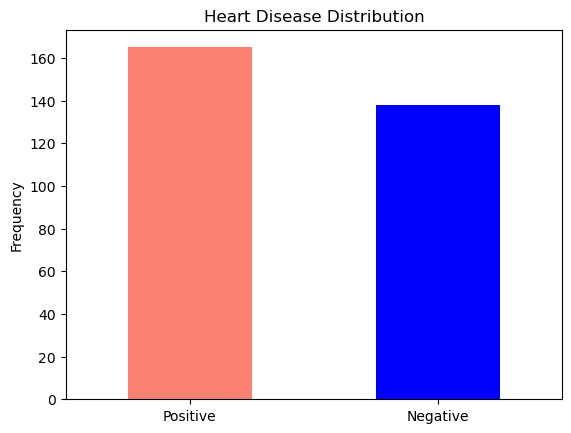

In [4]:
# display(dataset['target'].value_counts().rename(index={1:"Positive", 0:"Negative"}))

# Display targets in a Bar Graph and rename column labels
dataset['target'].value_counts().rename(index={1: "Positive", 0: "Negative"}).plot(kind='bar',
                                                                                   legend=False,
                                                                                   color=[
                                                                                       'salmon', 'blue'],
                                                                                   xlabel="",
                                                                                   ylabel="Frequency",
                                                                                   title="Heart Disease Distribution",
                                                                                   rot=0)

### Missing Value Check / General Insight


In [5]:
# Display Null Values and Transpose the data
display(pd.DataFrame(dataset.isna().sum()).T)

# Describe the dataset
display(dataset.describe())

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


### Heart Disease Frequency according to Sex


sex,0,1
target,,
0,24,114
1,72,93


(array([0, 1]), [Text(0, 0, 'Negative'), Text(1, 0, 'Positive')])

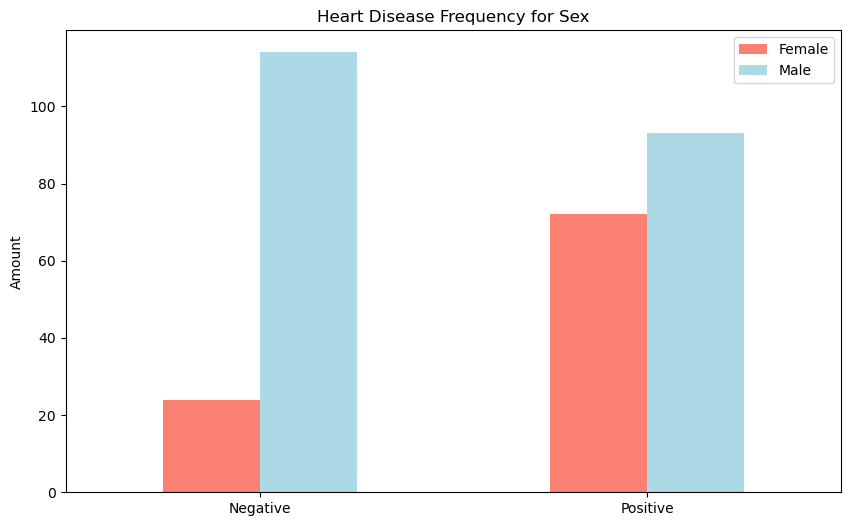

In [6]:
# Display a crosstab of target count by sex
display(pd.crosstab(index=dataset['target'], columns=dataset['sex']))

# Create a bar graph of target count by sex and rename columns
pd.crosstab(index=dataset['target'], columns=dataset['sex']).rename(index={1: "Positive", 0: "Negative"}).plot(kind="bar",
                                                                                                               figsize=(
                                                                                                                   10, 6),
                                                                                                               color=["salmon", "lightblue"])

# Plot formatting...
plt.title("Heart Disease Frequency for Sex")
plt.xlabel("")
plt.ylabel("Amount")
plt.legend(["Female", "Male"])
plt.xticks(rotation=0)

### Age vs. Max Heart Rate for Heart Disease


Text(0.5, 1.0, 'Heart Disease (Age vs Max Heart Rate)')

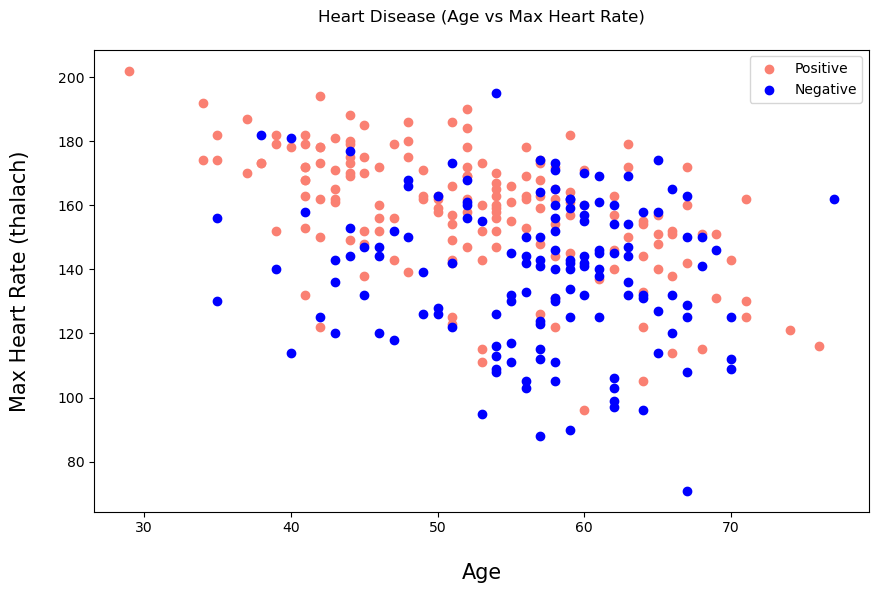

In [7]:
# Create a figure
plt.figure(figsize=(10, 6))

# Scatter with positive samples
plt.scatter(dataset['age'][dataset['target'] == 1],
            dataset['thalach'][dataset['target'] == 1],
            c='salmon')

# Scatter with negative samples
plt.scatter(dataset['age'][dataset['target'] == 0],
            dataset['thalach'][dataset['target'] == 0],
            c='blue')

# Plot Formatting
plt.legend(['Positive', 'Negative'])
plt.xlabel('Age',
           fontsize=15,
           labelpad=20)
plt.ylabel('Max Heart Rate (thalach)',
           fontsize=15,
           labelpad=20)
plt.title('Heart Disease (Age vs Max Heart Rate)',
          pad=20)

### Age Distribution


Text(0.5, 1.0, 'Age Distribution')

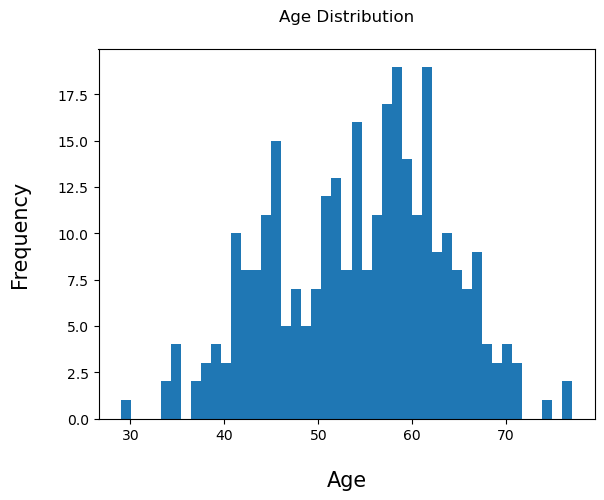

In [8]:
# Plot a histogram
dataset['age'].plot.hist(bins=45)

# Plot formatting
plt.xlabel('Age',
           fontsize=15,
           labelpad=20)
plt.ylabel('Frequency',
           fontsize=15,
           labelpad=20)
plt.title("Age Distribution",
          pad=20)

### Heart Disease Frequency per Chest Pain Type


Text(0.5, 1.0, 'Heart Disease Frequency per Chest Pain Type')

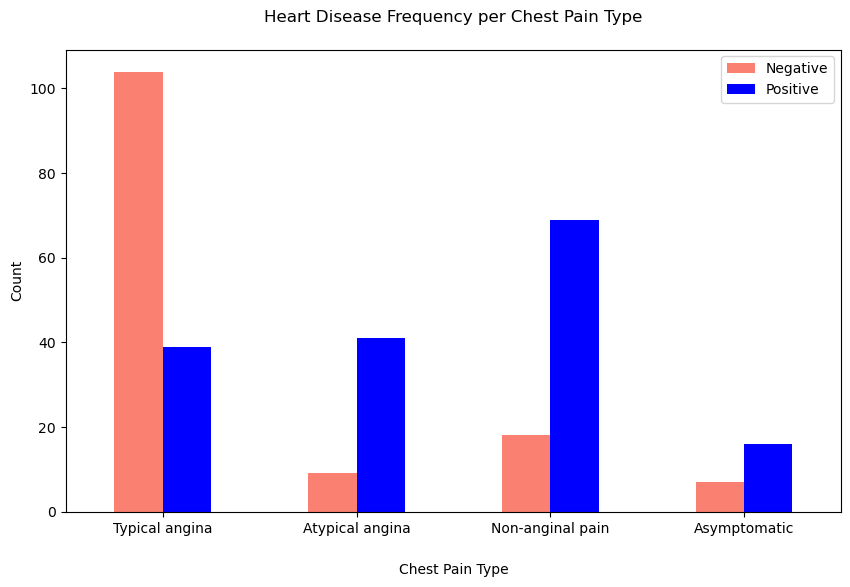

In [9]:
# Display a crosstab
pd.crosstab(index=dataset['cp'], columns=dataset['target'])

# Plot bar chart and rename columns
pd.crosstab(index=dataset['cp'], columns=dataset['target']).rename(index={0: 'Typical angina',
                                                                          1: 'Atypical angina',
                                                                          2: 'Non-anginal pain',
                                                                          3: 'Asymptomatic'}).plot(kind='bar',
                                                                                                   figsize=(
                                                                                                       10, 6),
                                                                                                   color=['salmon', 'blue'])

# Plot Formatting
plt.xticks(rotation=0)
plt.xlabel('Chest Pain Type',
           labelpad=20)
plt.ylabel('Count')
plt.legend(['Negative', 'Positive'])
plt.title('Heart Disease Frequency per Chest Pain Type',
          pad=20)

### Correlation Matrix Heatmap


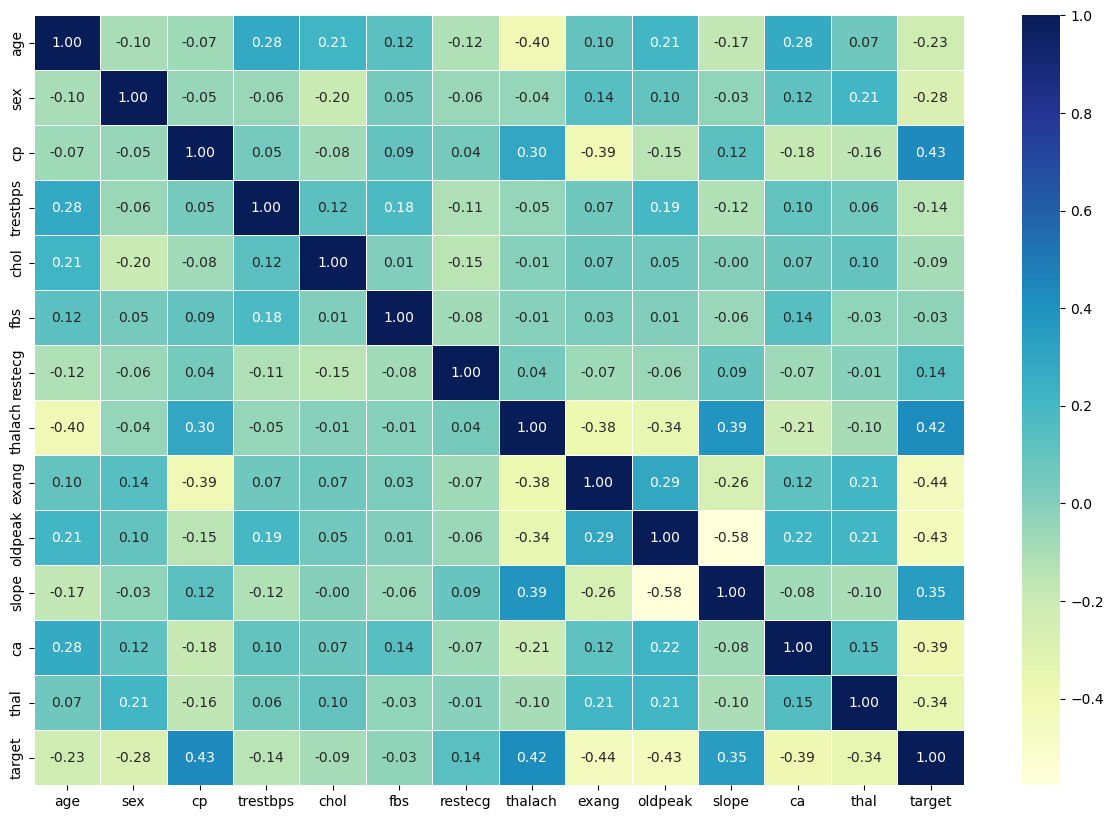

In [10]:
# Set a variable for correlation matrix
corr_matrix = dataset.corr()

# Set-up an Object Orriented plot
fig, ax = plt.subplots(figsize=(15, 10))

# Plot heatmap using seaborn
ax = sns.heatmap(corr_matrix,
                 annot=True,
                 linewidths=0.5,
                 fmt=".2f",
                 cmap="YlGnBu",
                 )

## 3. Data Preprocessing


In [11]:
# Assuming raw_dataset is defined and loaded elsewhere
dataset = raw_dataset.copy()

# Define the categorical features you want to one-hot encode
categorical_features = ["cp"]

# Initialize the OneHotEncoder
one_hot = OneHotEncoder()

# Create the ColumnTransformer with 'passthrough' for the remainder
transformer = ColumnTransformer(
    transformers=[
        ("one_hot", one_hot, categorical_features)
    ],
    remainder="passthrough"  # Keep the remaining columns
)

# Apply the transformer to the dataset
dataset_transformed = transformer.fit_transform(dataset)

# Get the original column names excluding the ones used for one-hot encoding
original_columns = [
    col for col in dataset.columns if col not in categorical_features]

# Generate new column names for the one-hot encoded features
one_hot_feature_names = [f'cp{index+1}' for index in range(
    one_hot.fit_transform(dataset[categorical_features]).shape[1])]

# Combine the new one-hot feature names with the original column names
new_column_names = one_hot_feature_names + original_columns

# Convert the output to a DataFrame
dataset_transformed_df = pd.DataFrame(
    dataset_transformed, columns=transformer.get_feature_names_out())

# Now rename the columns to remove any added prefixes from the remainder columns
# This involves matching the transformed column names with our new_column_names list
dataset_transformed_df.columns = new_column_names
# Check the DataFrame
dataset = dataset_transformed_df
display(dataset.head())

,cp1,cp2,cp3,cp4,age,sex,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,0.0,0.0,0.0,1.0,63.0,1.0,145.0,233.0,1.0,0.0,150.0,0.0,2.3,0.0,0.0,1.0,1.0
1,0.0,0.0,1.0,0.0,37.0,1.0,130.0,250.0,0.0,1.0,187.0,0.0,3.5,0.0,0.0,2.0,1.0
2,0.0,1.0,0.0,0.0,41.0,0.0,130.0,204.0,0.0,0.0,172.0,0.0,1.4,2.0,0.0,2.0,1.0
3,0.0,1.0,0.0,0.0,56.0,1.0,120.0,236.0,0.0,1.0,178.0,0.0,0.8,2.0,0.0,2.0,1.0
4,1.0,0.0,0.0,0.0,57.0,0.0,120.0,354.0,0.0,1.0,163.0,1.0,0.6,2.0,0.0,2.0,1.0


## 4. Modelling


### Define Machine Learning Models


In [12]:
# Set-up Training and Testing data...
np.random.seed(42)
X = dataset.drop(columns='target')
y = dataset['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Correct non Contiguous Error with KNN
# Ensure Input Data is in the Correct Format
X_train_np = X_train.to_numpy()
X_test_np = X_test.to_numpy()

# Ensure Data is Contiguous
X_train = np.ascontiguousarray(X_train_np)
X_test = np.ascontiguousarray(X_test_np)

# Put models in a dictionary
models = {"Logistic Regression": LogisticRegression(max_iter=1000),
          "KNN": KNeighborsClassifier(),
          "Random Forest": RandomForestClassifier()}

# Create a function to fit and score


def fit_and_score(models, X_train, X_test, y_train, y_test):
    """
    Fits and evaluates machine learning models...
    """
    np.random.seed(42)

    # Dictionary to keep model scores
    model_scores = {}

    # Fit and evaluate each model...
    for name, model in models.items():
        model.fit(X_train, y_train)
        model_scores[name] = model.score(X_test, y_test)
        print(f"{name}: {model.score(X_test, y_test)}")

    return model_scores

### Score and compare initial models


Logistic Regression: 0.8688524590163934
KNN: 0.6885245901639344
Random Forest: 0.8688524590163934


(array([0, 1, 2]),
 [Text(0, 0, 'Logistic Regression'),
  Text(1, 0, 'KNN'),
  Text(2, 0, 'Random Forest')])

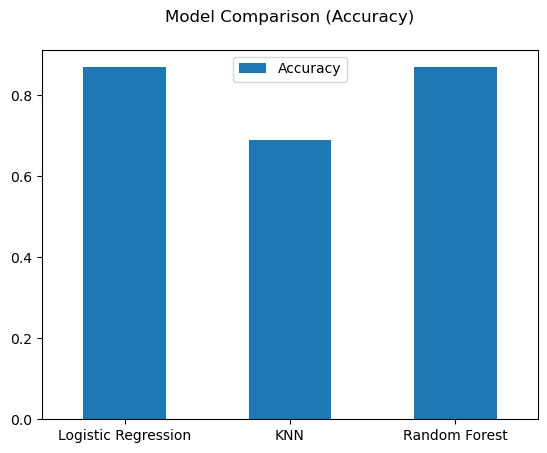

In [13]:
# Score initial models
model_scores = fit_and_score(models=models,
                             X_train=X_train,
                             X_test=X_test,
                             y_train=y_train,
                             y_test=y_test)

# Plot scoring results
model_compare = pd.DataFrame(model_scores, index=['Accuracy'])
model_compare.T.plot(kind='bar')

# Plot Formatting...
plt.title("Model Comparison (Accuracy)",
          pad=20)
plt.xticks(rotation=0)

### Hyperparameter Tuning


#### K-Neighbors


In [14]:
train_scores = []
test_scores = []

# Create list of different values for K-Neighbors
neighbors = range(1, 21, 1)

# Set-up KNN instance
KNN = KNeighborsClassifier()

# Loop through all of the Neighbors
for i in neighbors:
    np.random.seed(42)
    KNN.set_params(n_neighbors=i)
    KNN.fit(X_train, y_train)
    train_scores.append(KNN.score(X_train, y_train))
    test_scores.append(KNN.score(X_test, y_test))

    # Uncomment below to see the results of each loop
    # print(f'{i}-Neighbors Accuracy:')
    # print(f'Training Data: {KNN.score(X_train,y_train)*100:.2f}%')
    # print(f'Test Data: {KNN.score(X_test,y_test)*100:.2f}%')
    # print('')

Maximum KNN Score on the train data = 100.00% / 1 Neighbors
Maximum KNN Score on the test data = 75.41% / 11 Neighbors


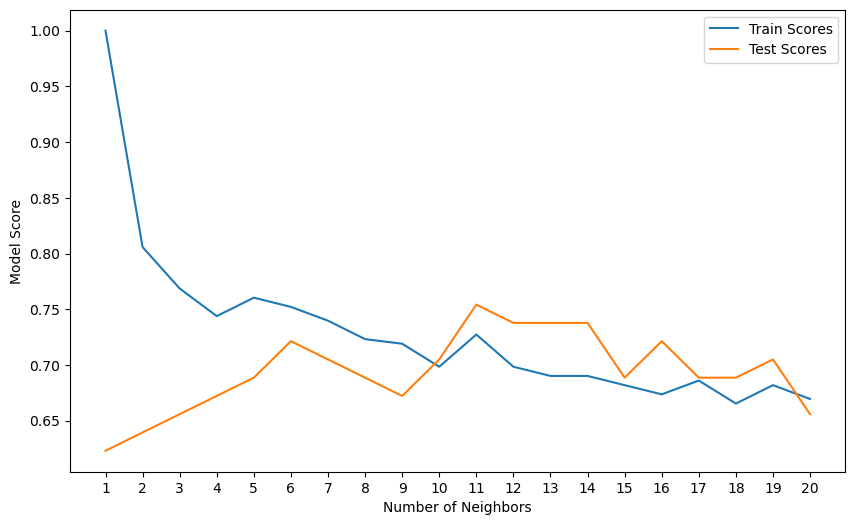

In [15]:
# Initialize Plot
plt.figure(figsize=(10, 6))

# Plot comparision between Train and Test Scores by # of Neighbors
plt.plot(neighbors, train_scores, label="Train Scores")
plt.plot(neighbors, test_scores, label="Test Scores")

# Plot formatting
plt.xticks(np.arange(1, 21, 1))
plt.xlabel("Number of Neighbors")
plt.ylabel("Model Score")
plt.legend()

print(
    f"Maximum KNN Score on the train data = {max(train_scores)*100:.2f}% / {train_scores.index(max(train_scores))+1} Neighbors")
print(
    f"Maximum KNN Score on the test data = {max(test_scores)*100:.2f}% / {test_scores.index(max(test_scores))+1} Neighbors")

#### Logistic Regression (Randomized Search Cross Validation)


In [16]:
# Create a hyperparameter grid for Logistic Regression
log_reg_grid = {
    "C": np.logspace(-10, 10, 50),
    "solver": ["liblinear"],
    "penalty": ["l1", "l2"]
}

# Implement RandomizedSearchCV for model
rs_log_reg = RandomizedSearchCV(LogisticRegression(max_iter=5000),
                                param_distributions=log_reg_grid,
                                cv=5,
                                n_iter=80,
                                verbose=True)

# Fit random hyperparameter model for Logistic Regression
rs_log_reg.fit(X_train, y_train)
print(f'The best hyperparameters found are: {rs_log_reg.best_params_}')
print(
    f'The test score with the best hyperparameters is: {rs_log_reg.score(X_test,y_test)}')

Fitting 5 folds for each of 80 candidates, totalling 400 fits
The best hyperparameters found are: {'solver': 'liblinear', 'penalty': 'l2', 'C': 0.2442053094548655}
The test score with the best hyperparameters is: 0.8688524590163934


#### Random Forest Classifier (Randomized Search Cross Validation)


In [18]:
# Create a hyperparameter grid for Random Forest Classifier
rfc_grid = {"n_estimators": np.arange(10, 1000, 50),
            "max_depth": [None, 3, 5, 10],
            "min_samples_split": np.arange(2, 20, 2),
            "min_samples_leaf": np.arange(1, 20, 2)}

# Implement RandomizedSearchCV for model
rs_rfc = RandomizedSearchCV(RandomForestClassifier(),
                            param_distributions=rfc_grid,
                            cv=5,
                            n_iter=20,
                            verbose=True)

# Fit random hyperparameter model for Random Forest Classifier
rs_rfc.fit(X_train, y_train)
print(f'The best hyperparameters found are: {rs_rfc.best_params_}')
print(
    f'The test score with the best hyperparameters is: {rs_rfc.score(X_test,y_test)}')

Fitting 5 folds for each of 20 candidates, totalling 100 fits


The best hyperparameters found are: {'n_estimators': 110, 'min_samples_split': 8, 'min_samples_leaf': 7, 'max_depth': 10}
The test score with the best hyperparameters is: 0.8688524590163934


#### Logistic Regression (Grid Search Cross Validation)


In [19]:
# Logistic Regression with GridSearchCV
log_reg_grid = {
    "C": np.logspace(-10, 10, 50),
    "solver": ["liblinear"],
    "penalty": ["l1", "l2"]
}

# Implement GridSearchCV for model
gs_log_reg = GridSearchCV(LogisticRegression(max_iter=5000),
                          param_grid=log_reg_grid,
                          cv=5,
                          verbose=True)

# Fit grid hyperparameter model for Logistic Regression
gs_log_reg.fit(X_train, y_train)
print(f'The best hyperparameters found are: {gs_log_reg.best_params_}')
print(
    f'The test score with the best hyperparameters is: {gs_log_reg.score(X_test,y_test)}')

Fitting 5 folds for each of 100 candidates, totalling 500 fits


The best hyperparameters found are: {'C': 0.2442053094548655, 'penalty': 'l2', 'solver': 'liblinear'}
The test score with the best hyperparameters is: 0.8688524590163934


## 5. Evaluation


In [20]:
# Set up predictions for the target in a variable
y_preds = gs_log_reg.predict(X_test)

### ROC Curve / AUC Score


Text(0.5, 0, 'False Positive Rate')

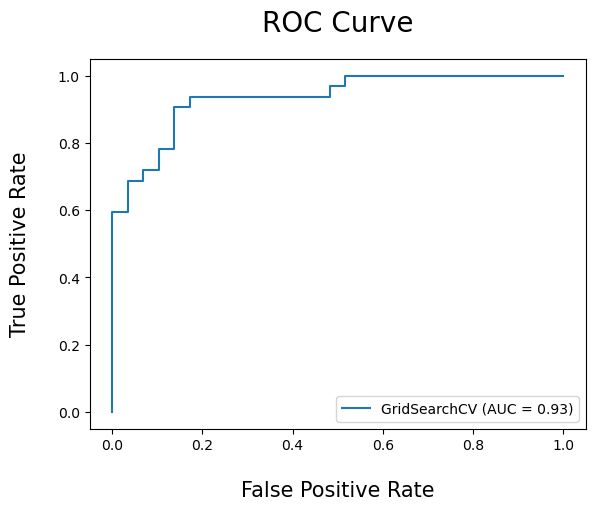

In [21]:
# Plot ROC curve from the selected estimator
RocCurveDisplay.from_estimator(gs_log_reg, X_test, y_test)

# Plot Formatting
plt.title("ROC Curve",
          pad=20,
          fontsize=20)
plt.ylabel("True Positive Rate",
           labelpad=20,
           fontsize=15)
plt.xlabel("False Positive Rate",
           labelpad=20,
           fontsize=15)

### Confusion Matrix


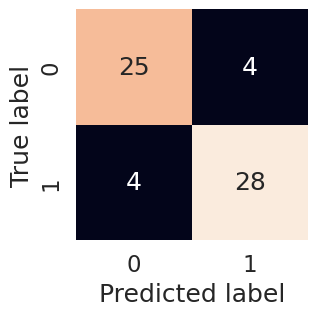

In [22]:
# Confusion Matrix
sns.set_theme(font_scale=1.5)  # Increase font size

# Define a function for a reusable Confusion Matrix


def plot_conf_mat(y_test, y_preds):
    """
    Plots a confusion matrix using Seaborn's heatmap().
    """
    fig, ax = plt.subplots(figsize=(3, 3))
    ax = sns.heatmap(confusion_matrix(y_test, y_preds),
                     annot=True,  # Annotate the boxes
                     cbar=False)
    plt.xlabel("Predicted label")  # predictions go on the x-axis
    plt.ylabel("True label")  # true labels go on the y-axis


plot_conf_mat(y_test, y_preds)

### Classification report


In [23]:
# Show classification report
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

         0.0       0.86      0.86      0.86        29
         1.0       0.88      0.88      0.88        32

    accuracy                           0.87        61
   macro avg       0.87      0.87      0.87        61
weighted avg       0.87      0.87      0.87        61



### Cross Validated Metrics


In [24]:
# Create a new classifier with the best params
clf = LogisticRegression(C=gs_log_reg.best_params_['C'],
                         solver=gs_log_reg.best_params_['solver'])

# Cross-Validated Evaluation Metrics
cv_accuracy = cross_val_score(estimator=clf,
                              X=X_test,
                              y=y_test,
                              cv=5,
                              scoring="accuracy").mean()

cv_precision = cross_val_score(estimator=clf,
                               X=X_test,
                               y=y_test,
                               cv=5,
                               scoring="precision").mean()

cv_recall = cross_val_score(estimator=clf,
                            X=X_test,
                            y=y_test,
                            cv=5,
                            scoring="recall").mean()

cv_f1 = cross_val_score(estimator=clf,
                        X=X_test,
                        y=y_test,
                        cv=5,
                        scoring="f1").mean()

print(f"Mean Cross-Validated Accuracy = {cv_accuracy*100:.2f}%")
print(f"Mean Cross-Validated Precision = {cv_precision}")
print(f"Mean Cross-Validated Recall = {cv_recall}")
print(f"Mean Cross-Validated F1-Score = {cv_f1}")

Mean Cross-Validated Accuracy = 88.46%
Mean Cross-Validated Precision = 0.8964285714285716
Mean Cross-Validated Recall = 0.9047619047619048
Mean Cross-Validated F1-Score = 0.8873260073260074


## 6. Feature Importance


Text(0.5, 0, 'Features')

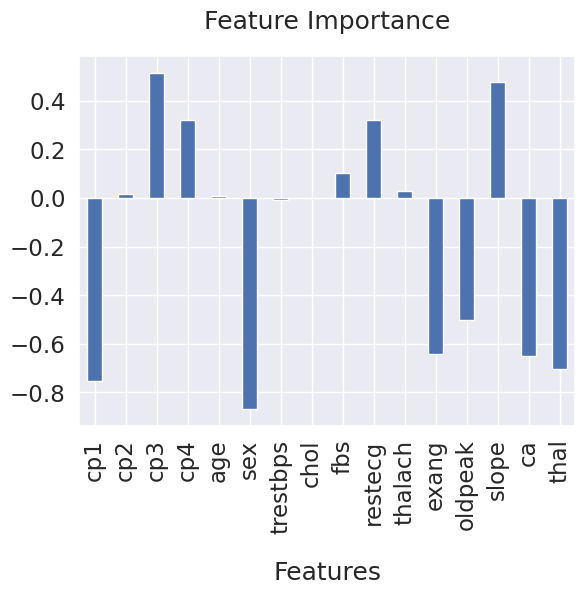

In [25]:
# Create a new classifier with the best params
clf = LogisticRegression(C=gs_log_reg.best_params_['C'],
                         solver=gs_log_reg.best_params_['solver'])

# Fit the classifier with the training data
clf.fit(X_train, y_train)

# Match coefs of features to columns and create a DataFrame
feature_dict = dict(zip(dataset.columns, list(clf.coef_[0])))
feature_df = pd.DataFrame(feature_dict, index=[0])

# Plot the coeficients in a Bar Graph
feature_df.T.plot(kind="bar",
                  legend=False)

# Plot formatting
plt.title("Feature Importance",
          pad=20)

plt.xlabel('Features',
           labelpad=20)

## 7. Conclusion


In this project, the best accuracy score achieved with the optimized logistic regression model was below the minimum expected threshold of 0.95. Despite not reaching this ambitious goal, the project revealed the inherent potential of the logistic regression model in classifying the presence of heart disease. Recognizing the current limitations, there is an acknowledgment of the need to further enhance the model's predictive capability.

Some possible avenues to improving the results include:

- Enriching the dataset with additional features
- Consulting on existing features with subject matter experts
- increasing the number of data records to train the model on
- Exploring new machine learning algorithms

With these steps there is a confident expectation to move closer to or surpass the desired accuracy threshold.
